# Research question 8.

## Do sequels or franchise movies follow different patterns in their endings compared to standalone films? 

Investigating whether franchise movies are more likely to have open-ended or happy endings to encourage future installments could reveal a unique trend in storytelling within cinematic universes.

##### Importations

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, kstest, mannwhitneyu

In [59]:
# path
DATA_FOLDER = '../../src/data/'
MOVIE_DATASET = DATA_FOLDER + 'movies_dataset_final.tsv'

#### Statistics

In [53]:
def load_dataset(file_path, sep='\t'):
    """
    Function to load a dataset from a specified file path.

    Parameters:
    file_path (str): The path to the dataset file.
    sep (str): The separator used in the dataset file (default is tab-separated).

    Returns:
    pandas.DataFrame: The loaded dataset as a DataFrame.
    """
    try:
        # Load the dataset
        dataset = pd.read_csv(file_path, sep='\t')
        print(f"Dataset loaded successfully from {file_path}")
        return dataset
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
    except pd.errors.ParserError:
        print(f"Error: There was an issue parsing the file at {file_path}. Please check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Since films belonging to a collection have a collection number, while standalone films are labeled as 'NaN,' we created a binary column where '1' marks films in a collection and '0' marks standalone films.

In [54]:
def clean_dataset(dataset):
    """
    Function to clean the dataset by creating a binary column indicating if the movie belongs to a collection.
    
    Parameters:
    dataset (pandas.DataFrame): The dataset to be cleaned.
    
    Returns:
    pandas.DataFrame: The cleaned dataset.
    """
    # Create a binary column indicating if the movie belongs to a collection
    dataset['in_collection'] = dataset['collection'].notna().astype(int)

    return dataset

#### Counting and visualizing the distribution of standalone vs. collection films

We use undersampling here because it helps to create a balanced dataset, where both groups (standalone and collection films) have an equal number of films. This is important for ensuring that the analysis isn't biased toward the more frequent group. We could have also used oversampling, but undersampling is chosen here to avoid artificially inflating the number of data points in the smaller group, which could lead to overfitting

In [55]:
def plot_barplots_before_after_undersampling(movies, movies_resampled):
    # Create the figure with two subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Subplots placed next to each other

    # Bar plot before undersampling (showing the number of movies per group)
    sns.countplot(x='in_collection', data=movies, palette='coolwarm', hue='in_collection', ax=axes[0])
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(['Standalone', 'Collection'])
    axes[0].set_xlabel('Type of Film')
    axes[0].set_ylabel('Number of Movies')
    axes[0].set_title('Number of Movies Before Undersampling')

    # Bar plot after undersampling (showing the number of movies per group)
    sns.countplot(x='in_collection', data=movies_resampled, palette='coolwarm', hue='in_collection', ax=axes[1])
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(['Standalone', 'Collection'])
    axes[1].set_xlabel('Type of Film')
    axes[1].set_ylabel('Number of Movies')
    axes[1].set_title('Number of Movies After Undersampling')

    # Display the figure
    plt.tight_layout()
    plt.show()



#### The goal of this code is to perform statistical tests (Kolmogorov-Smirnov for normality and independent t-test) to compare the ending scores between collection (franchise) and standalone movies.

We first use the Kolmogorov-Smirnov test to check if the scores follow a normal distribution. If normality is violated (p-value < 0.05), we use the Mann-Whitney U test. If normality holds, we proceed with an independent t-test.

The independent t-test compares the mean scores between the two groups. A p-value < 0.05 indicates a statistically significant difference, suggesting that film type (franchise vs. standalone) may influence the ending scores. If normality is not met, the Mann-Whitney U test serves as a non-parametric alternative.

In [56]:

def perform_statistical_tests(movies_resampled):
    """
    Perform Kolmogorov-Smirnov test for normality and Independent T-Test on the resampled dataset.

    Parameters:
    movies_resampled (pandas.DataFrame): The resampled dataset containing the 'Score' and 'in_collection' columns.

    Returns:
    None: Prints the results of the statistical tests.
    """
    # Separate the scores for collection and standalone films
    scores_collection = movies_resampled[movies_resampled['in_collection'] == 1]['Score']
    scores_standalone = movies_resampled[movies_resampled['in_collection'] == 0]['Score']
    
    # Kolmogorov-Smirnov test for normality
    ks_collection = kstest(scores_collection.dropna(), 'norm')
    ks_standalone = kstest(scores_standalone.dropna(), 'norm')

    print(f"\nKolmogorov-Smirnov Test for Normality:")
    print(f"Collection Films: p-value = {ks_collection.pvalue:.4f}")
    print(f"Standalone Films: p-value = {ks_standalone.pvalue:.4f}")

    # If normality assumption is violated (p-value < 0.05), use the Mann-Whitney U test (non-parametric)
    if ks_collection.pvalue < 0.05 or ks_standalone.pvalue < 0.05:
        print("\nNormality assumption violated. Using Mann-Whitney U test...")
        stat, p_value = mannwhitneyu(scores_collection, scores_standalone, alternative='two-sided')
        print(f"Mann-Whitney U Test: p-value = {p_value:.4f}")
    else:
        # Independent T-Test
        t_stat, p_value = ttest_ind(scores_collection, scores_standalone, nan_policy='omit')
        print(f"\nIndependent T-Test: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")
        
    # Statistical significance interpretation
    if p_value < 0.05:
        print("\nThe difference between collection and standalone films' scores is statistically significant.")
    else:
        print("\nThere is no statistically significant difference between collection and standalone films' scores.")


In [60]:

def analyze_movie_scores(MOVIE_DATASET):
    # Dataset loading
    movies = load_dataset(MOVIE_DATASET)

    # Clean the dataset
    movies_cleaned = clean_dataset(movies)

    # Mean scores for standalone vs collection films (before undersampling)
    mean_scores = movies_cleaned.groupby('in_collection')['Score'].mean()

    print(f"\n{'-'*40}")
    print("Average Scores for Standalone vs. Collection Movies (before undersampling)")
    print(f"{'-'*40}")
    print(f"{'Standalone Movies (0)':<25}: {mean_scores[0]}")
    print(f"{'Collection Movies (1)':<25}: {mean_scores[1]}")
    print(f"{'-'*40}")

    # Quantiles for each group
    quantiles = movies_cleaned.groupby('in_collection')['Score'].quantile([0.25, 0.5, 0.75]).unstack()
    quantiles = quantiles.round(2)

    print("\n" + "="*40)
    print("Quantiles for Standalone and Collection Movies (before undersampling)")
    print("="*40)
    print(f"{'Quantile':<10} {'Standalone (0)':<20} {'Collection (1)'}")
    print("-"*40)

    for quantile in [0.25, 0.5, 0.75]:
        print(f"{quantile*100:.0f}th Percentile: {quantiles[quantile][0]:<20} {quantiles[quantile][1]}")

    # Plot barplots before and after undersampling
    plot_barplots_before_after_undersampling(movies_cleaned, movies_resampled)

    # Perform statistical tests on the resampled dataset
    perform_statistical_tests(movies_resampled)

    # Post-undersampling analysis
    mean_scores_resampled = movies_resampled.groupby('in_collection')['Score'].mean()
    print("\nAverage Scores for Standalone vs Collection Movies (After Undersampling):")
    print(f"Standalone Films: {mean_scores_resampled[0]}")
    print(f"Collection Films: {mean_scores_resampled[1]}")

    # Boxplot for resampled data
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='in_collection', y='Score', data=movies_resampled, palette='coolwarm', hue='in_collection')
    plt.xticks([0, 1], ['Standalone', 'Collection'], rotation=0)
    plt.ylabel('Score')
    plt.title('Comparison of Scores Between Standalone and Collection Movies')
    plt.show()

    # Visualize scores over years for both groups
    scores_by_year = movies_resampled.groupby(['Movie release date', 'in_collection'])['Score'].mean().unstack()
    scores_by_year.plot(kind='line', figsize=(10, 6), marker='o')
    plt.xlabel('Release Year')
    plt.ylabel('Average Score')
    plt.title('Average Scores of Standalone and Collection Movies by Release Year')
    plt.legend(['Standalone', 'Collection'])
    plt.show()


Dataset loaded successfully from ../../src/data/movies_dataset_final.tsv

----------------------------------------
Average Scores for Standalone vs. Collection Movies (before undersampling)
----------------------------------------
Standalone Movies (0)    : 0.05710735360171146
Collection Movies (1)    : 0.05245809989322952
----------------------------------------

Quantiles for Standalone and Collection Movies (before undersampling)
Quantile   Standalone (0)       Collection (1)
----------------------------------------
25th Percentile: -0.05                -0.05
50th Percentile: 0.05                 0.04
75th Percentile: 0.17                 0.16


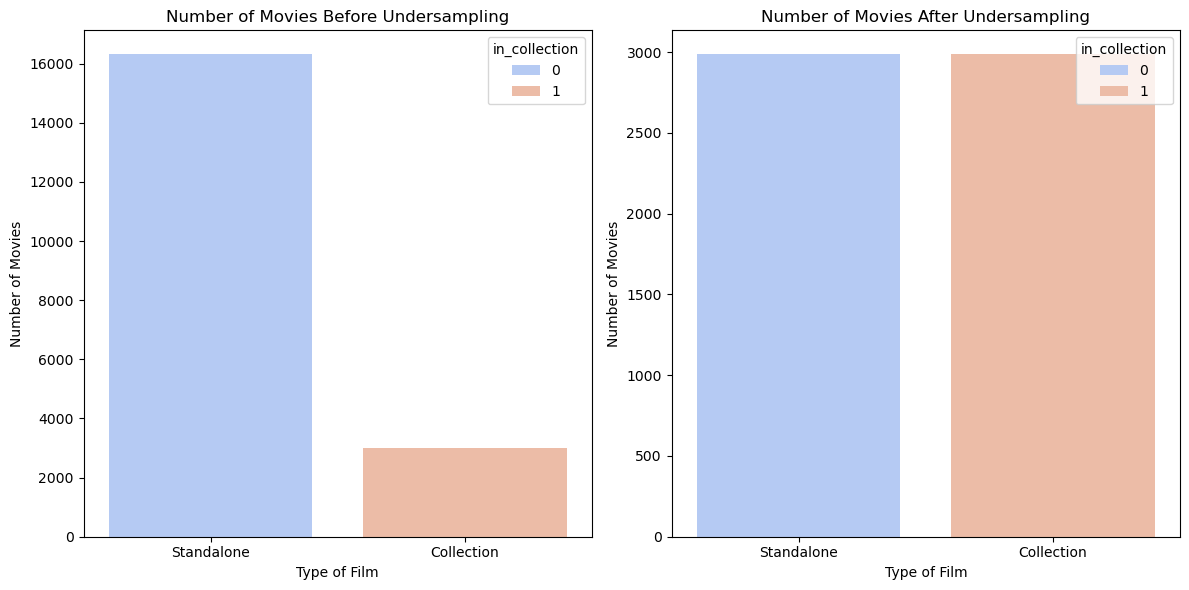


Kolmogorov-Smirnov Test for Normality:
Collection Films: p-value = 0.0000
Standalone Films: p-value = 0.0000

Normality assumption violated. Using Mann-Whitney U test...
Mann-Whitney U Test: p-value = 0.8881

There is no statistically significant difference between collection and standalone films' scores.

Average Scores for Standalone vs Collection Movies (After Undersampling):
Standalone Films: 0.05082445122898324
Collection Films: 0.05245809989322952


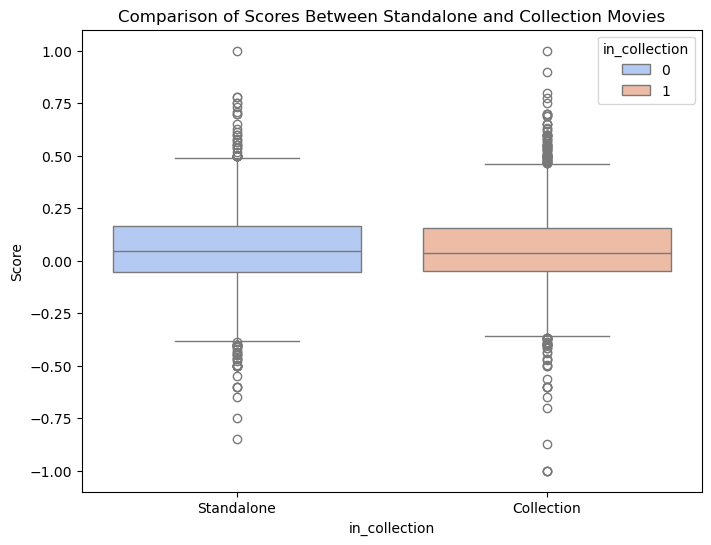

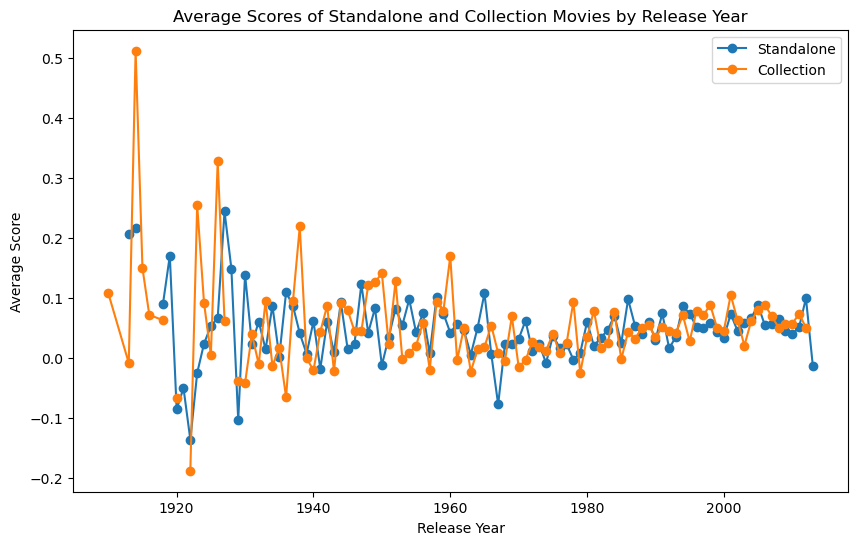

In [61]:
analyze_movie_scores(MOVIE_DATASET)